In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set a professional style for the plots
sns.set_theme(style="whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


In [22]:
# In[2]:
# Define the paths to your generated performance model files
npu_file = 'npu-only.csv'
neupims_file = 'performance_models/neupims_off.csv'

# Check if the files exist before proceeding
if not os.path.exists(npu_file) or not os.path.exists(neupims_file):
    print("Error: Performance model CSV files not found.")
    print(f"Please ensure '{npu_file}' and '{neupims_file}' exist before running.")
else:
    # Load the datasets
    df_npu = pd.read_csv(npu_file)
    df_neupims = pd.read_csv(neupims_file)

    # Merge the two dataframes for direct comparison
    # We rename the latency columns to avoid conflicts
    merged_df = pd.merge(
        df_npu.rename(columns={'latency(ns)': 'latency_npu'}),
        df_neupims.rename(columns={'latency(ns)': 'latency_neupims'}),
        on=['model', 'layer_name', 'input', 'kv_cache'],
        suffixes=('_npu', '_neupims')
    )

    # Calculate the speedup of NeuPIMs over the NPU-only baseline
    # Speedup = Time_old / Time_new
    merged_df['speedup'] = merged_df['latency_npu'] / merged_df['latency_neupims']

    print("Data loaded and merged successfully. Displaying the first 5 rows:")
    print(merged_df.head())

Data loaded and merged successfully. Displaying the first 5 rows:
  hardware_npu    model layer_name  input  kv_cache  latency_npu  \
0     npu-only  GPT3-7B    ffn_res     64         0         1269   
1     npu-only  GPT3-7B    ffn_res     64         1         1269   
2     npu-only  GPT3-7B    ffn_res     64         2         1269   
3     npu-only  GPT3-7B    ffn_res     64         3         1269   
4     npu-only  GPT3-7B    ffn_res     64         4         1269   

  hardware_neupims  latency_neupims   speedup  
0      neupims_off             1204  1.053987  
1      neupims_off             1204  1.053987  
2      neupims_off             1204  1.053987  
3      neupims_off             1204  1.053987  
4      neupims_off             1204  1.053987  


In [23]:
df_npu['layer_name'].unique()

array(['ffn_res', 'ffn_fc1', 'ffn_fc2', 'attn_ln', 'attn', 'attn_proj',
       'ffn_gelu', 'attn_QKVgen', 'attn_res', 'ffn_ln'], dtype=object)

In [24]:
df_neupims['layer_name'].unique()

array(['attn', 'attn_QKVgen', 'attn_ln', 'attn_proj', 'attn_res',
       'ffn_fc1', 'ffn_fc2', 'ffn_gelu', 'ffn_ln', 'ffn_res'],
      dtype=object)

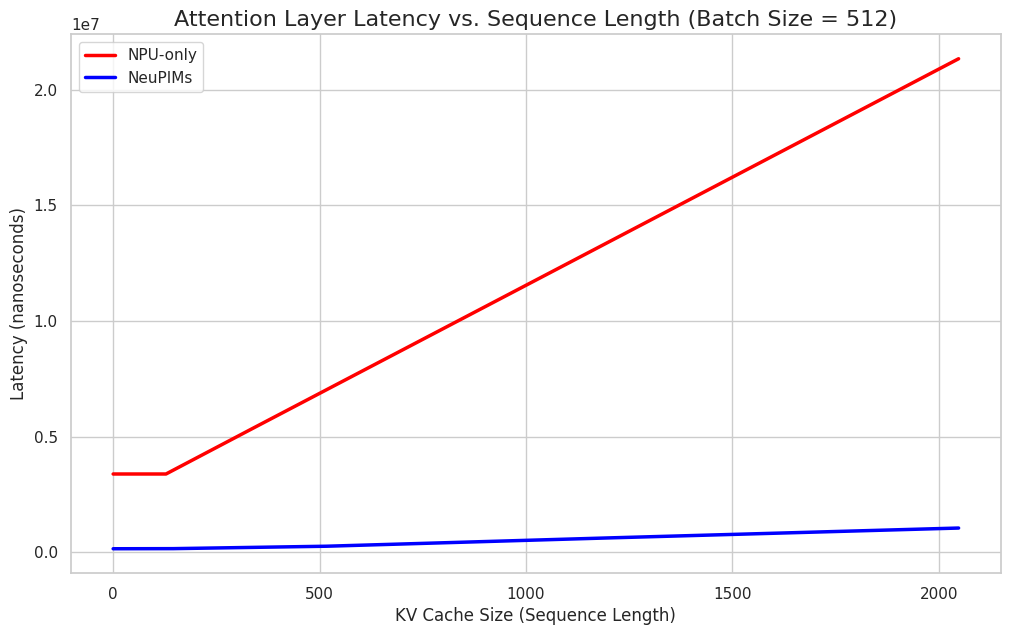

In [25]:
# In[3]:
# Filter the data for the 'attn' layer and a large batch size (e.g., 512)
attn_df = merged_df[(merged_df['layer_name'] == 'attn') & (merged_df['input'] == 512)]

plt.figure(figsize=(12, 7))
sns.lineplot(data=attn_df, x='kv_cache', y='latency_npu', label='NPU-only', color='red', linewidth=2.5)
sns.lineplot(data=attn_df, x='kv_cache', y='latency_neupims', label='NeuPIMs', color='blue', linewidth=2.5)

plt.title('Attention Layer Latency vs. Sequence Length (Batch Size = 512)', fontsize=16)
plt.xlabel('KV Cache Size (Sequence Length)', fontsize=12)
plt.ylabel('Latency (nanoseconds)', fontsize=12)
plt.legend()
plt.show()

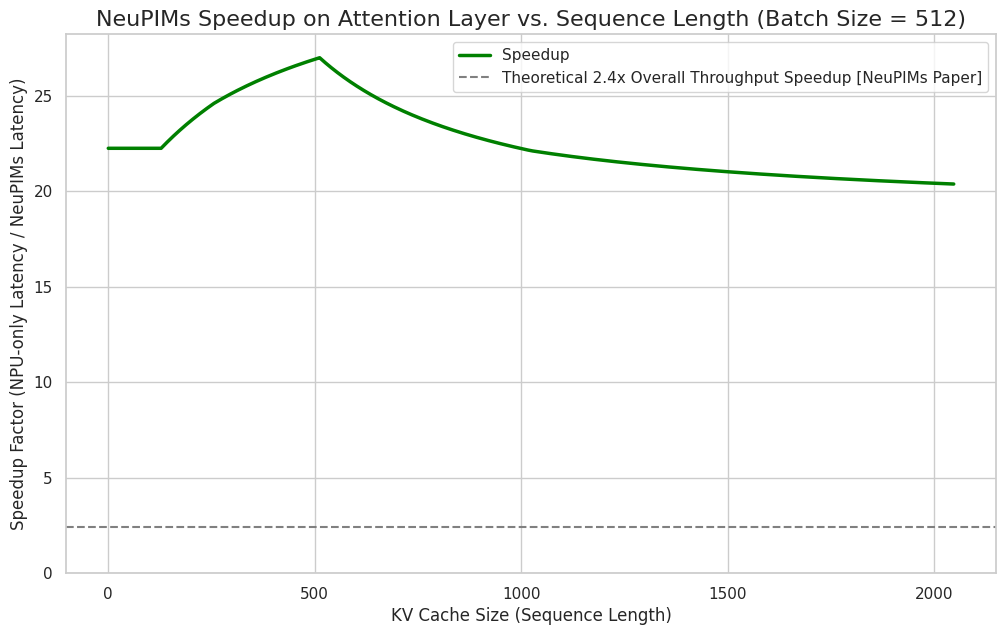

In [27]:
# In[4]:
# We can reuse the attn_df from the previous cell
if not attn_df.empty:
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=attn_df, x='kv_cache', y='speedup', label='Speedup', color='green', linewidth=2.5)

    # Add a horizontal line for the theoretical 2.4x speedup from the paper for reference
    plt.axhline(y=2.4, color='gray', linestyle='--', label='Theoretical 2.4x Overall Throughput Speedup [NeuPIMs Paper]')

    plt.title('NeuPIMs Speedup on Attention Layer vs. Sequence Length (Batch Size = 512)', fontsize=16)
    plt.xlabel('KV Cache Size (Sequence Length)', fontsize=12)
    plt.ylabel('Speedup Factor (NPU-only Latency / NeuPIMs Latency)', fontsize=12)
    plt.legend()
    plt.ylim(bottom=0) # Ensure y-axis starts at 0
    plt.show()

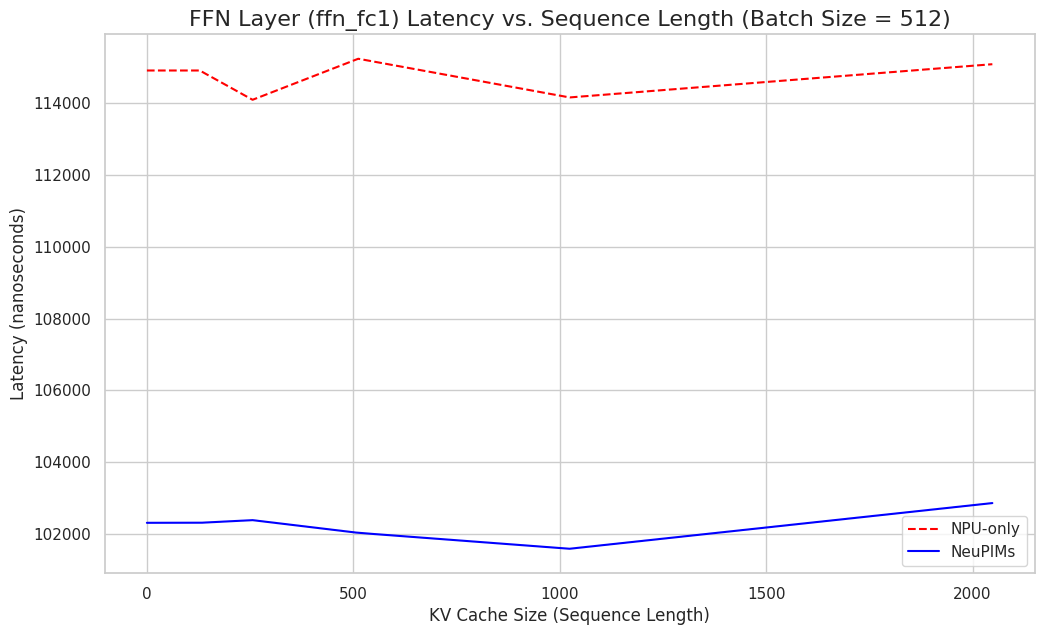

In [28]:
# In[5]:
# Filter for a representative FFN layer (e.g., 'ffn_fc1') at a fixed batch size
ffn_df = merged_df[(merged_df['layer_name'] == 'ffn_fc1') & (merged_df['input'] == 512)]

if ffn_df.empty:
    print("No data found for 'ffn_fc1' layer at batch size 512. Please check your CSV files.")
else:
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=ffn_df, x='kv_cache', y='latency_npu', label='NPU-only', color='red', linestyle='--')
    sns.lineplot(data=ffn_df, x='kv_cache', y='latency_neupims', label='NeuPIMs', color='blue')

    plt.title('FFN Layer (ffn_fc1) Latency vs. Sequence Length (Batch Size = 512)', fontsize=16)
    plt.xlabel('KV Cache Size (Sequence Length)', fontsize=12)
    plt.ylabel('Latency (nanoseconds)', fontsize=12)
    plt.legend()
    plt.show()

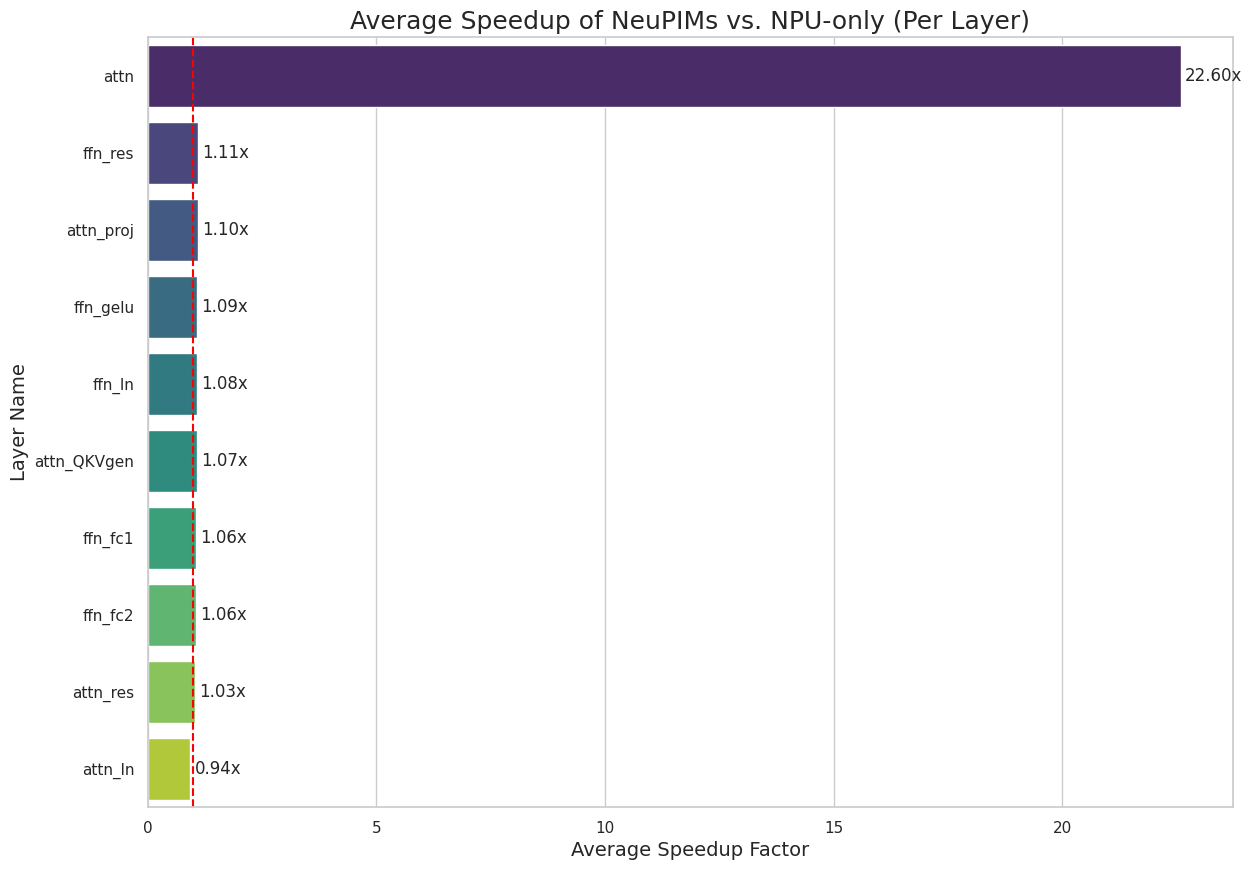

In [30]:
# In[6]:
# Calculate the average speedup for each layer across all tested conditions
layer_speedup = merged_df.groupby('layer_name')['speedup'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(14, 10))
barplot = sns.barplot(
    data=layer_speedup,
    x='speedup',
    y='layer_name',
    hue='layer_name',    # assign y variable to hue
    palette='viridis',
    legend=False         # hide redundant legend
)

plt.title('Average Speedup of NeuPIMs vs. NPU-only (Per Layer)', fontsize=18)
plt.xlabel('Average Speedup Factor', fontsize=14)
plt.ylabel('Layer Name', fontsize=14)
plt.axvline(x=1.0, color='red', linestyle='--') # Add a line at 1.0x for reference

# Add labels to the bars for clarity
for i in barplot.containers:
    barplot.bar_label(i, fmt='%.2fx', padding=3)

plt.show()